#### 1) Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

In [1]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.datasets import load_diabetes

In [3]:
X, y = load_diabetes(return_X_y=True)

#### Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

#### Напишем функцию, реализующую предсказание в градиентном бустинге.

In [5]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

#### В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [6]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

#### Используем $L_{2}$ loss $L(y, z) = (y-z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z-y)$. Реализуем ее также в виде функции (коэффициент 2 можно отбросить).

In [7]:
def bias(y, z):
    return (y - z)

#### Реализуем функцию обучения градиентного бустинга.

In [8]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

#### Теперь обучим несколько моделей с разными значениями n_trees и max_depth.
#### eta = const = 0.1 (так как нам нужно выяснить зависимость результатов от количества деревьев и максимальной глубины.

In [53]:
eta = 0.1
n_trees = [n + 2 for n in range(50)]
# n_trees = [50]
max_depth = [d + 2 for d + 1 in range(20)]
# max_depth = [(d + 2) * 2 for d in range(10)]

# print(n_trees, max_depth)

dataset = []

for n in n_trees:
    print(n)
    coefs = [1] * n
    for d in max_depth:
        print(d)
        trees, train_errors, test_errors = gb_fit(n, d, X_train, X_test, y_train, y_test, coefs, eta)
#         evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)
        train_prediction = gb_predict(X_train, trees, coefs, eta)
        test_prediction = gb_predict(X_test, trees, coefs, eta)
        dataset.append([n, d, mean_squared_error(y_train, train_prediction), mean_squared_error(y_test, test_prediction)])

50
4
6
8
10
12
14
16
18
20
22


#### Построим графики зависимости ошибки на обучающей и тестовой выборках от количества деревьев.

In [41]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Value')
    plt.ylabel('MSE')
    plt.xlim(n_trees[0], n_trees[-1])
    plt.plot(n_trees, train_err, label='train error')
    plt.plot(n_trees, test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

In [42]:
dataset
import pandas as pd
table = pd.DataFrame(dataset, columns=['n trees', 'max depth', 'train error', 'test error'])
# table[table['n trees'] == 11]
table.head()

,n trees,max depth,train error,test error
0,2,2,21022.916941,17473.788832
1,2,3,20848.889437,17389.457662
2,2,4,20692.642041,17440.764441
3,2,5,20498.524522,17406.656784
4,2,6,20327.971992,17546.712385


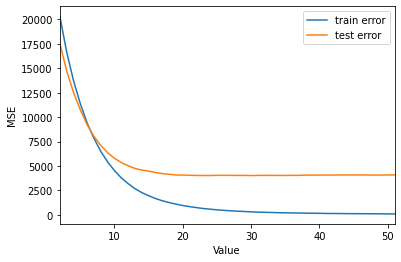

In [43]:
depth = 6
data = [dataset[x] for x in [depth - 2 + len(max_depth) * y for y in range(len(n_trees))]]
# print(data)
train_errors = [x[2] for x in data]
test_errors = [x[3] for x in data]
get_error_plot(n_trees, train_errors, test_errors)

#### Построим графики зависимости ошибки на обучающей и тестовой выборках от максимальной глубины.

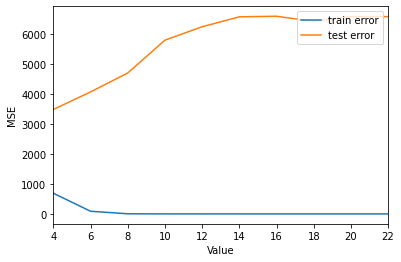

In [58]:
trees = 20
data2 = [dataset[x] for x in [(trees - 2) * len(max_depth) + y for y in range(len(max_depth))]]
# print(data2)
train_errors2 = [x[2] for x in data2]
test_errors2 = [x[3] for x in data2]
get_error_plot(max_depth, train_errors2, test_errors2)

#### При увеличении количества деревьев у алгоритма велика вероятность переобучиться. На обучающей выборке ошибка уменьшается, а на тестовой - увеличивается.
#### При увеличении максимальной глубины сначала ошибка уменьшается и на обучающей, и на тестовой выборке, но после max_depth = 20 выходит на плато. 

#### 2) *Задача повышенной сложности. * Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.